## Сборный проект
#### Описание проекта

Задача:
- разобраться, как ведут себя пользователи мобильного приложения.
- изучить воронку продаж, узнайть, как пользователи доходят до покупки. 
- исследовать результаты A/A/B-эксперимента 

#### Описание данных
Каждая запись в логе — это действие пользователя, или событие.

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


#### Содержание:
1. <a href='#Предобработка данных'>Предобработка данных</a>
2. <a href='#Анализ данных'>Анализ данных</a>
3. <a href='#Воронка событий'>Воронка событий</a>
4. <a href='#Анализ результатов эксперимента'> Анализ результатов эксперимента</a>  

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
import math as mth
from pandas.plotting import register_matplotlib_converters
from plotly import graph_objects as go

### 1. Предобработка данных
<a id='Предобработка данных'></a>

In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
logs.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

In [5]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event_name         244126 non-null object
device_id_hash     244126 non-null int64
event_timestamp    244126 non-null int64
exp_id             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [6]:
logs.duplicated().sum()

413

In [7]:
logs[logs.duplicated(keep=False)==True]

,event_name,device_id_hash,event_timestamp,exp_id
452,MainScreenAppear,5613408041324010552,1564474784,248
453,MainScreenAppear,5613408041324010552,1564474784,248
2348,CartScreenAppear,1694940645335807244,1564609899,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3572,MainScreenAppear,434103746454591587,1564628377,248
...,...,...,...,...
242359,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246
242634,MainScreenAppear,4097782667445790512,1565206618,246


In [8]:
logs = logs.drop_duplicates()

In [9]:
logs['datetime'] = pd.to_datetime(logs['event_timestamp'], unit='s')

In [10]:
logs['date'] = logs['datetime'].dt.date

In [11]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
event_name         243713 non-null object
device_id_hash     243713 non-null int64
event_timestamp    243713 non-null int64
exp_id             243713 non-null int64
datetime           243713 non-null datetime64[ns]
date               243713 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


В данных нет пропусков. 
В данных обнаружено и удалено 413 дубликатов методами pd.duplicated() и pd.drop_duplicates()
Названия колонок изменены на 'event_name', 'device_id_hash', 'event_timestamp', 'exp_id' для удобства работы с данными.
Введены две новые колонки:
- 'datetime' -содержащая информацию о дате и времени события в формате datetime64[ns]. Создана как произодное из колонки event_timestamp методом pd.to_datetime(),
- 'date'  - содержащая информацию только о дате события.


### 2. Анализ данных
<a id='Анализ данных'></a>

In [12]:
print('Всего в логе {} событий'.format(len(logs)))

list_of_event_name = logs['event_name'].unique()
print('Всего уникальных событий - {}'.format(len(list_of_event_name)))

Всего в логе 243713 событий
Всего уникальных событий - 5


In [13]:
total_unique_id = len(logs['device_id_hash'].unique())
print('Всего в логе {} уникальных пользователя'.format(total_unique_id))

Всего в логе 7551 уникальных пользователя


In [14]:
print('В среднем на каждого пользователя приходится {:.0f} события'.format(len(logs)/(len(logs['device_id_hash'].unique()))))

В среднем на каждого пользователя приходится 32 события


In [15]:
print('В логах хранятся события за период', logs['date'].min(), '-', logs['date'].max())
print('За {} дней'.format(len(logs['date'].unique())))

В логах хранятся события за период 2019-07-25 - 2019-08-07
За 14 дней


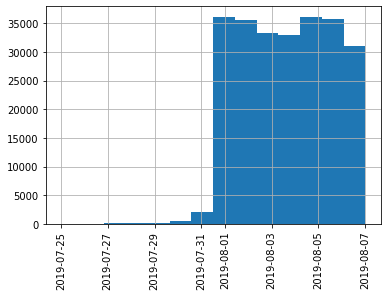

In [16]:
register_matplotlib_converters()

plt.xticks(rotation=90)
logs['date'].hist(bins = 14)
list_of_date = list(logs['date'].unique())


За период 2019-07-25 - 2019-07-31 данные не выглядят полными. Их слишком мало. 

Фактически анализируемый период будет 2019-08-01 - 2019-08-07

In [17]:
list_of_date = list_of_date[7:]

In [18]:
logs_week = logs.loc[logs['date'].isin(list_of_date)]

In [19]:
dif_old_new = 100-(len(logs_week)*100/len(logs))
print('Исключив первую неделю из исследования, убрали {:.1f}% данных'.format(dif_old_new))

Исключив первую неделю из исследования, убрали 1.2% данных


In [20]:
old_group = logs.groupby('exp_id').agg({'device_id_hash': 'nunique'}).reset_index()
new_group = logs_week.groupby('exp_id').agg({'device_id_hash': 'nunique'}).reset_index()
new_group.columns = ['exp_id', 'new_id_hash']
old_group = pd.merge(old_group, new_group, on = 'exp_id')

In [21]:
old_group['difference'] = old_group['device_id_hash'] - old_group['new_id_hash']
old_group['%_dif'] = 100 * old_group['difference']/old_group['device_id_hash']
old_group

,exp_id,device_id_hash,new_id_hash,difference,%_dif
0,246,2489,2484,5,0.200884
1,247,2520,2513,7,0.277778
2,248,2542,2537,5,0.196696


После удаления данных остались пользователи всех трех групп. Разница между количеством пользоателей до удаления данных и после не превышает 0.3%

#### Вывод
1. Всего в логе 243713 событий. Всего уникальных событий - 5

2. В среднем на каждого пользователя приходится 32 события.

3. В логах хранятся события за период 2019-07-25 - 2019-08-07 (14 дней)

4. За период 2019-07-25 - 2019-07-31 данные не выглядят полными. Их слишком мало. Фактически анализируемый период принят 2019-08-01 - 2019-08-07

5. Исключив первую неделю из исследования, убрали 1.2% данных. После удаления данных остались пользователи всех трех групп. Разница между количеством пользоателей до удаления данных и после не превышает 0.3%

### 3. Воронка событий
<a id='Воронка событий'></a>

In [22]:
events_freq = logs_week.groupby('event_name').agg({
    'datetime': 'count'
}).sort_values(by = 'datetime', ascending = False)
events_freq

,datetime
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


In [23]:
events_popular = logs_week.groupby('event_name').agg({
    'device_id_hash': 'nunique'
}).sort_values(by = 'device_id_hash', ascending = False)
events_popular.columns = ['unique_id_count']
display(events_popular)
unique_id = len(logs_week['device_id_hash'].unique())


,unique_id_count
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [24]:
events_popular['%_of_tital_id'] = 100* events_popular['unique_id_count']/ unique_id

In [25]:
unique_id_first_step = logs_week.loc[logs_week['event_name'] == "MainScreenAppear", 'device_id_hash'].unique().tolist()

list_of_id_from_nowhere = []

In [26]:
for element in logs_week['device_id_hash'].unique():
    if element not in unique_id_first_step:
        list_of_id_from_nowhere.append(element)

In [27]:
print(len(list_of_id_from_nowhere))
print("Что составляет {:.2f} % от всех уникальных пользователей".format(100 * len(list_of_id_from_nowhere)/unique_id))
print("Пользователи, прошедшие этап Tutorial, составляют {:.2f} % от всех уникальных пользователей".format(100*840/unique_id))

115
Что составляет 1.53 % от всех уникальных пользователей
Пользователи, прошедшие этап Tutorial, составляют 11.15 % от всех уникальных пользователей


Существует 115 пользователей, которые не совершали действия "MainScreenAppear", но при этом существуют в общем списке уникальных id за исследуемую неделю. Это всего 1.5% от всех пользователей. "MainScreenAppear" будем считать первым обязательным этапом для пользователя. 
А этап 'Tutorial' будем считать необязательным. Его проходило 11.2% всех пользователей. 

In [28]:
#Для пользователей посчитаем время первого срабатывания каждого события методом pivot_table()
users = logs_week.pivot_table(
        index='device_id_hash', 
        columns='event_name', 
        values='datetime',
        aggfunc='min')

In [29]:
#Узнаем, сколько пользователей переходило с этапа на этап.
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

main_screen = users[step_1].shape[0]
offer_screen = users[step_2].shape[0]
cart_screen = users[step_3].shape[0]
payment_success = users[step_4].shape[0]

print('Посетителей, прошедших этап "MainScreenAppear":', main_screen)
print('Посетителей, прошедших этап "MainScreenAppear" и "OffersScreenAppear"', offer_screen)
print('Посетителей, затем прошедших этап "CartScreenAppear":', cart_screen)
print('А прошедших этап "PaymentScreenSuccessful"', payment_success)
step_by_step = pd.DataFrame(data=[
    ['MainScreenAppear', main_screen], 
    ['OffersScreenAppear', offer_screen], 
    ['CartScreenAppear', cart_screen],
    ['PaymentScreenSuccessful', payment_success]], columns = ['event_name', 'uniq_user'])

Посетителей, прошедших этап "MainScreenAppear": 7419
Посетителей, прошедших этап "MainScreenAppear" и "OffersScreenAppear" 4201
Посетителей, затем прошедших этап "CartScreenAppear": 1767
А прошедших этап "PaymentScreenSuccessful" 454


In [30]:
events_popular = events_popular.reset_index()

In [31]:
events_popular = pd.merge(events_popular, step_by_step, on = 'event_name')
step_by_step

,event_name,uniq_user
0,MainScreenAppear,7419
1,OffersScreenAppear,4201
2,CartScreenAppear,1767
3,PaymentScreenSuccessful,454


In [32]:
events_popular['%_all_step_by_step'] = 100 * events_popular['uniq_user']/ events_popular['unique_id_count']

In [33]:
events_popular

,event_name,unique_id_count,%_of_tital_id,uniq_user,%_all_step_by_step
0,MainScreenAppear,7419,98.473586,7419,100.000000
1,OffersScreenAppear,4593,60.963632,4201,91.465273
2,CartScreenAppear,3734,49.561986,1767,47.321907
3,PaymentScreenSuccessful,3539,46.973719,454,12.828483


Первые два этапа хорошо совпадают по пользователям. А вот последние два - совсем нет. Пользователи приходят к оплате каким-то другим способом. Возможно, опалчивают не он-лайн, а наличными курьеру при доставке? (если возможен такой способ оплаты)
Или пользователи предпочитаею делать заказ не с главного экрана, а переходя по сторонним ссылкам сразу к экрану оплаты? Существует возможность быстрого платежа, которая позволяет миновать последние два шага?

In [34]:
step_by_step['%_step_transfer'] = step_by_step['uniq_user'].pct_change().round(3) * 100
display(step_by_step)
print("От этапа MainScreenAppear до этапа PaymentScreenSuccessful доходят {:.2f} % пользователей"
      .format(100*454/7419))

,event_name,uniq_user,%_step_transfer
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4201,-43.4
2,CartScreenAppear,1767,-57.9
3,PaymentScreenSuccessful,454,-74.3


От этапа MainScreenAppear до этапа PaymentScreenSuccessful доходят 6.12 % пользователей


In [36]:
fig = go.Figure(go.Funnel(
    y = step_by_step['event_name'],
    x = step_by_step['uniq_user']))

fig.show()

#### Вывод 
Самый большой % потери клиентов видно с этапа CartScreenAppear на этап PaymentScreenSuccessful. Возможно что-то не так с оплатой картой он-лайн, ведь 74% пользователей прошедших этап CartScreenAppear не проходят этап PaymentScreenSuccessful (это только  6.12% от пользователей, прошедших первый этап)

### 4. Анализ результатов эксперимента
<a id='Анализ результатов эксперимента'></a>

#### 4.1 Сколько пользователей в каждой экспериментальной группе?

In [37]:
uniq_users_in_group = logs_week.groupby('exp_id').agg({'device_id_hash' : 'nunique'}).reset_index()
display(uniq_users_in_group)

,exp_id,device_id_hash
0,246,2484
1,247,2513
2,248,2537


#### 4.2 А/А-тест

In [38]:
logs_a1 = logs_week.query('exp_id == 246')
logs_a2 = logs_week.query('exp_id == 247')

In [39]:
log_a1_groupby =logs_a1.groupby('event_name').agg({
    'device_id_hash' : 'nunique'
}).sort_values(by = 'device_id_hash', ascending = False).reset_index()
log_a1_groupby['from_total'] = log_a1_groupby['device_id_hash']/ (uniq_users_in_group['device_id_hash'][0])
display(log_a1_groupby)


log_a2_groupby = logs_a2.groupby('event_name').agg({
    'device_id_hash' : 'nunique'
}).sort_values(by = 'device_id_hash', ascending = False).reset_index()
log_a2_groupby['from_total'] = log_a2_groupby['device_id_hash']/ (uniq_users_in_group['device_id_hash'][1])
display(log_a2_groupby)

,event_name,device_id_hash,from_total
0,MainScreenAppear,2450,0.986312
1,OffersScreenAppear,1542,0.620773
2,CartScreenAppear,1266,0.509662
3,PaymentScreenSuccessful,1200,0.483092
4,Tutorial,278,0.111916


,event_name,device_id_hash,from_total
0,MainScreenAppear,2476,0.985277
1,OffersScreenAppear,1520,0.604855
2,CartScreenAppear,1238,0.492638
3,PaymentScreenSuccessful,1158,0.460804
4,Tutorial,283,0.112614


##### Проверяем гипотезу:
H0 = между долями пользователей, совершивших каждый из шагов в контрольных группах, нет значимой разницы


H1 = между долями пользователей, совершивших каждый из шагов в контрольных группах, есть значимая разница

In [40]:
# создаем функцию для проверки гипотез
def calculate_dif(a,b,c,d):
    alpha = .05 # критический уровень статистической значимости
    list_of_event_name = logs['event_name'].unique()
    for element in list_of_event_name:
        events = np.array([a.query('event_name == @element')['device_id_hash'], 
                           b.query('event_name == @element')['device_id_hash']])
        total = np.array([c, d])
    
    # прохождение этапа в первой группе:
        p1 = events[0]/total[0]

    # прохождение этапа во второй группе:
        p2 = events[1]/total[1]

    # прохождение этапов в комбинированном датасете:
        p_combined = (events[0] + events[1]) / (total[0] + total[1])

    # разница пропорций в датасетах
        difference = p1 - p2

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total[0] + 1/total[1]))

        p_value = (1 - distr.cdf(abs(z_value)))*2

        print('p-значение для этапа', element, ':', p_value)

        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        
        print('***')
    
calculate_dif(
    log_a1_groupby, 
    log_a2_groupby, 
    uniq_users_in_group['device_id_hash'][0], 
    uniq_users_in_group['device_id_hash'][1]
)

p-значение для этапа MainScreenAppear : [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа PaymentScreenSuccessful : [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа CartScreenAppear : [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа OffersScreenAppear : [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа Tutorial : [0.93769962]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***


По итогам проверки можно сделать вывод, что разбиение на группы работает корректно. Нет оснований считать группы 246 и 247 статистически разными.

#### 4.3 A/A/B тест


Всего проверяется 12 гипотез о статистической значимости долей в группах 246, 247, 248.

##### Сравниваем группу 246 (контроль) с группой 248 (тест)

##### Проверяем гипотезу:
H0 = между долями пользователей, совершивших каждый из шагов в группах, нет значимой разницы


H1 = между долями пользователей, совершивших каждый из шагов в группах, есть значимая разница

In [41]:
logs_b = logs_week.query('exp_id == 248')
log_b_groupby = logs_b.groupby('event_name').agg({
    'device_id_hash' : 'nunique'
}).sort_values(by = 'device_id_hash', ascending = False).reset_index()
log_b_groupby['from_total'] = log_b_groupby['device_id_hash']/ (uniq_users_in_group['device_id_hash'][2])
display(log_b_groupby)

,event_name,device_id_hash,from_total
0,MainScreenAppear,2493,0.982657
1,OffersScreenAppear,1531,0.603469
2,CartScreenAppear,1230,0.484825
3,PaymentScreenSuccessful,1181,0.465510
4,Tutorial,279,0.109972


In [42]:
   
calculate_dif(
    log_a1_groupby, 
    log_b_groupby, 
    uniq_users_in_group['device_id_hash'][0], 
    uniq_users_in_group['device_id_hash'][2]
)    

p-значение для этапа MainScreenAppear : [0.29497219]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа PaymentScreenSuccessful : [0.21225533]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа CartScreenAppear : [0.07842923]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа OffersScreenAppear : [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа Tutorial : [0.8264294]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***


##### Сравниваем группу 247 (контроль) с группой 248 (тест)

##### Проверяем гипотезу:
H0 = между долями пользователей, совершивших каждый из шагов в группах, нет значимой разницы


H1 = между долями пользователей, совершивших каждый из шагов в группах, есть значимая разница

In [43]:

calculate_dif(
    log_a2_groupby, 
    log_b_groupby, 
    uniq_users_in_group['device_id_hash'][1], 
    uniq_users_in_group['device_id_hash'][2]
)    

p-значение для этапа MainScreenAppear : [0.45870536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа PaymentScreenSuccessful : [0.73734151]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа CartScreenAppear : [0.57861979]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа OffersScreenAppear : [0.91978178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа Tutorial : [0.76532392]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***


##### Сравниваем группу 246+247 (контроль) с группой 248 (тест)

##### Проверяем гипотезу:
H0 = между долями пользователей, совершивших каждый из шагов в группах, нет значимой разницы


H1 = между долями пользователей, совершивших каждый из шагов в группах, есть значимая разница

In [44]:
logs_a = logs_week.query('exp_id != 248')
log_a_groupby = logs_a.groupby('event_name').agg({
    'device_id_hash' : 'nunique'
}).sort_values(by = 'device_id_hash', ascending = False).reset_index()
log_a_groupby['from_total'] = log_a_groupby['device_id_hash']/ (uniq_users_in_group['device_id_hash'][0] + uniq_users_in_group['device_id_hash'][0])
display(log_a_groupby)

,event_name,device_id_hash,from_total
0,MainScreenAppear,4926,0.991546
1,OffersScreenAppear,3062,0.616345
2,CartScreenAppear,2504,0.504026
3,PaymentScreenSuccessful,2358,0.474638
4,Tutorial,561,0.112923


In [45]:

calculate_dif(
    log_a_groupby, 
    log_b_groupby, 
    (uniq_users_in_group['device_id_hash'][1] + uniq_users_in_group['device_id_hash'][0]), 
    uniq_users_in_group['device_id_hash'][2]
)    

p-значение для этапа MainScreenAppear : [0.29424527]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа PaymentScreenSuccessful : [0.60042943]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа CartScreenAppear : [0.18175875]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа OffersScreenAppear : [0.4342555]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***
p-значение для этапа Tutorial : [0.76486247]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
***


#### Вывод
По итогам A/A/B теста не получилось найти статистически значимой разницы ни по одной из 12 гипоз между группами 246,247 и 248 при выбранном значеннии порога статистической значимсоти в 0.01. 
Тоже наблюдаемм при повышении уровня значимости до 0.05.

### Выводы
1. В данных нет пропусков. В данных обнаружено и удалено 413 дубликатов.
2. Всего в логе 243713 событий. Всего уникальных событий - 5. В среднем на каждого пользователя приходится 32 события.
3. В логах хранятся события за период 2019-07-25 - 2019-08-07 (14 дней). При этом за период 2019-07-25 - 2019-07-31 данные не выглядят полными. Их слишком мало. Фактически анализируемый период принят 2019-08-01 - 2019-08-07. 
4. Исключив первую неделю из исследования, убрали 1.2% данных. После удаления данных остались пользователи всех трех групп. Разница между количеством пользоателей до удаления данных и после не превышает 0.3%
5. Исходя из анализа данных, предполагаю такую последовательность прохождения этапов для пользователя: "MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful". 
    Количество посетителей, проходящих этапы последовательно, равны:
    - "MainScreenAppear": 7419
    - "OffersScreenAppear" 4201
    - "CartScreenAppear": 1767
    - "PaymentScreenSuccessful" 454
6. Самый большой % потери клиентов видно с этапа CartScreenAppear на этап PaymentScreenSuccessful. Возможно что-то не так с оплатой картой он-лайн, ведь 74% пользователей прошедших этап CartScreenAppear не проходят этап PaymentScreenSuccessful (это только 6.12% от пользователей, прошедших первый этап) 
7. По результатам А/А-теста статистической разницы между группами не выявлено.
8. По результатам А/А/В- теста  не получилось найти статистически значимой разницы ни по одной из 12 гипотез между группами 246,247 и 248 при выбранном значеннии порога статистической значимсоти в 0.01 и 0.05.
9. Результаты тестов показывают, что можно смело менять шрифты (или не менять) - пользователи не изменят свое поведение.
